In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [3]:
# read data
df = pd.read_csv("../input/digit-recognizer/train.csv")

data = df.to_numpy()

X_train = data[:,1:].T / 255
# do we need to normalize data to [0,1) ? 
y_train = data[:,0]

index:  1  label:  0
index:  2  label:  1
index:  3  label:  4
index:  4  label:  0
index:  5  label:  0
index:  6  label:  7
index:  7  label:  3
index:  8  label:  5
index:  9  label:  3


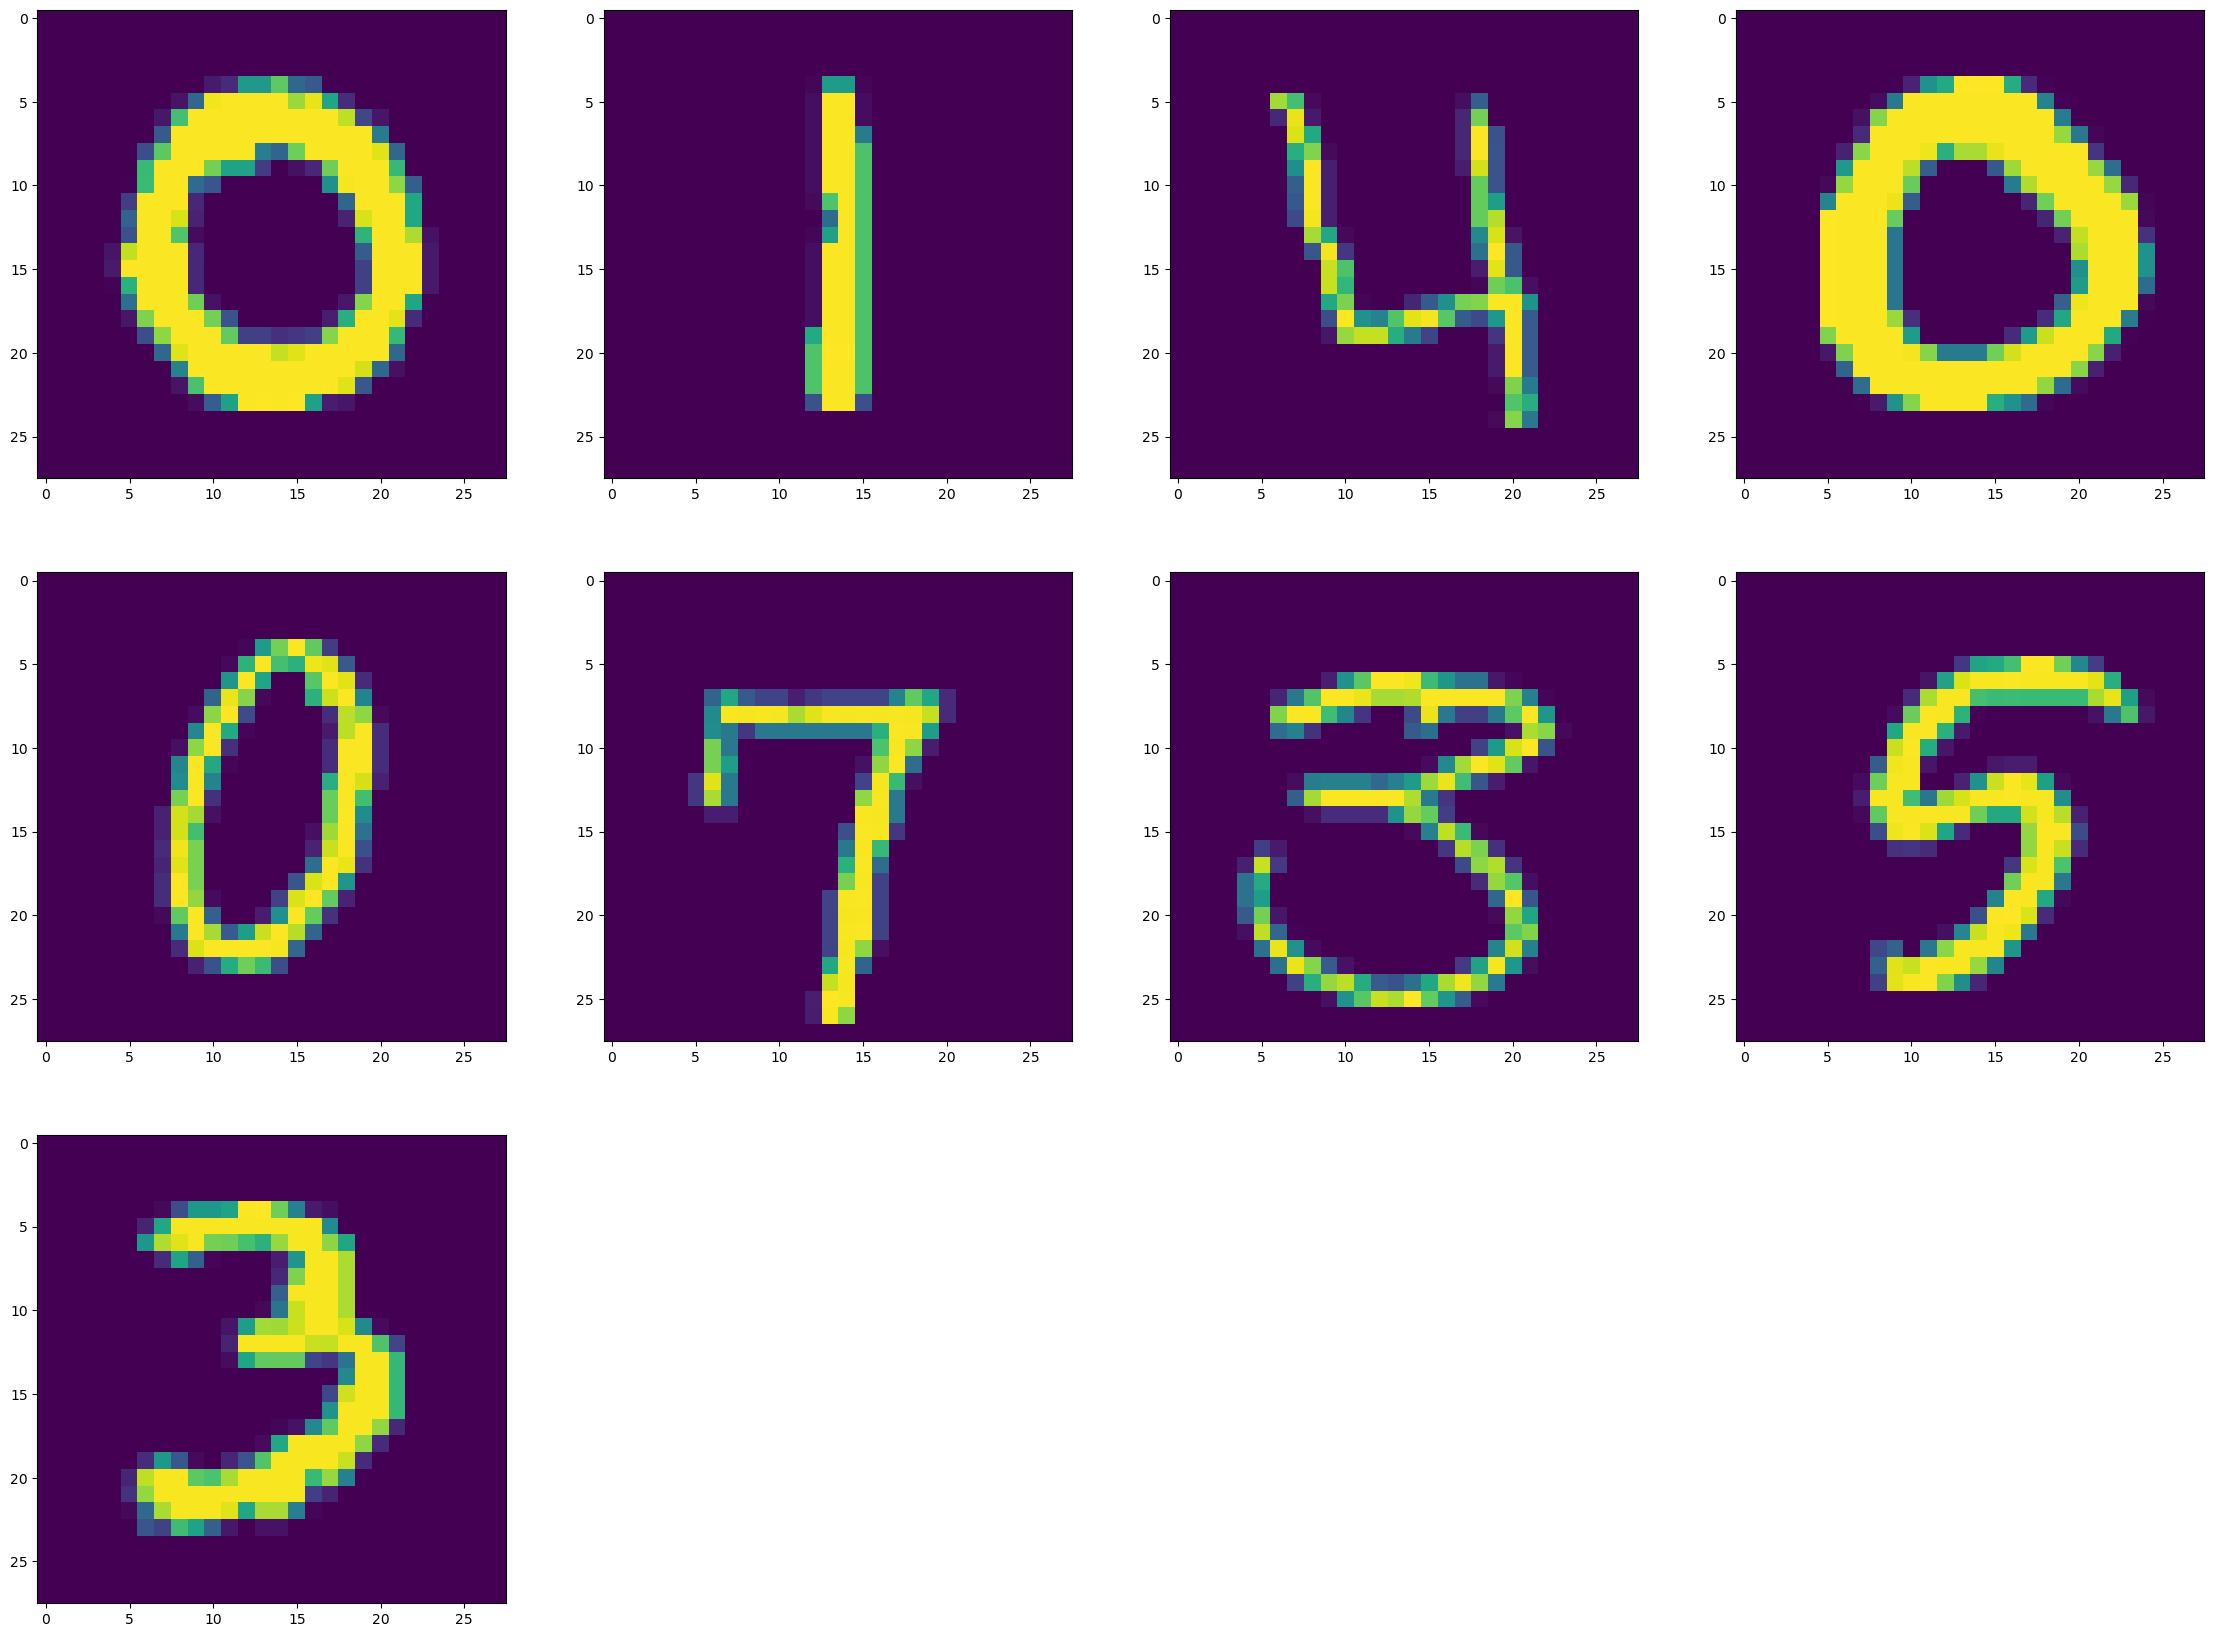

In [4]:
# Define some helper methods for displaying
def show_image(row):
    plt.imshow(X_train[:,row].reshape(28,28))
    print("index: ", row, " label: ", y_train[row])
    # print("label: ", Y_train[row])

fig = plt.figure(figsize=(28,28))
for i in range(1,10):
    fig.add_subplot(4,4,i)
    show_image(i)

plt.show()
    


```
# Define methods for neural network
# 
# Initialize matrices
#   W1, b1, W2, b2
#
# Forward propagation algorithm:
#   Where M = # pixels
#   Where N = # samples
# Layer 0:
#   X1 (M x N): initial training data
#               M: pixels (feature)
#               N: number of samples
#   W1 (M x K): initial weights.
#               K: a hyperparameter specifying the number of hidden units in the
#               first hidden layer. This is a design choice. Recommended to start conservative, and grad.
#               increase complexity as needed
#   b1 (K x 1): initial biases
#               But this needs to be broadcast across each column. W1.T.dot(X1) = a matrix of (K x N),
#               which cannot be directly added to b1. So for each column N, broadcast b1 to it.
# Layer 1: Activation layer 1
#   h (K x N) = g(W1.T . X1 + b1)
#   g = ReLU()
# Layer 2: Output Layer
#   W2: constrain to answers
#   b2: biases
#   y = softmax(W2 . A1 + b2)
#   y is a matrix of 10 x N, where each row represents probability distribution of most likely digit
#   softmax = e ** Zi / sum(j=1,K) e ** Zj
#       softmax converts vector of K real numbers into probability distribution of K possible outcomes
#   
# Backward propagation algorithm:
#   # use a distance formula 

# training algorithm (gradient_descent)
# 1) while iterations < total:
#   1) forward propagation
#   2) backward propagate
#   3) adjust weights and biases
# 2) training complete
#   1) can use model to predict number
```

In [14]:
def init_params(M, K): 
    W1 = 0.1*np.random.rand(M,K)
    b1 = 0.1*np.random.rand(K,1)
    W2 = 0.1*np.random.rand(K,10)
    b2 = 0.1*np.random.rand(10,1)
    return W1, b1, W2, b2

def ReLU(X):
    return np.maximum(X,0)

def deriv_ReLU(X):
    return X > 0

def forward_propagate_l1(W1, b1, X):
    # print(W1.dot(X)[:,1])
    # formula W1.T.dot(X) + b1 (which is broadcast to N columns)
    h = ReLU(W1.T.dot(X) + np.broadcast_to(b1,(len(b1),X.shape[1])))
    return h

def softmax(X):
    for j in range(X.shape[1]): # 10 x 42000
        shifted = X[:,j] - np.max(X[:,j]) # shift to avoid overflow errors from high e^x
        sum = np.sum(np.exp(shifted))
        for i in range(X.shape[0]): # 10
            X[i,j] = np.exp(shifted[i]) / sum
    return X

def output_layer(W2, b2, h):
    # TODO: note softmax is causing inf errors because exponents are too large
    y = softmax(W2.T.dot(h) + np.broadcast_to(b2,(len(b2),h.shape[1])))
    return y

def one_hot_encode(y_train):
    y = np.zeros((10,len(y_train)))
    for i in range(len(y_train)):
        y[y_train[i],i] = 1
    return y

def mean_square_loss(y, t):
    # Method 1: perhaps take the highest probability index in one col, one-hot encode that
    # then subtract against OHE y array, this will be 1 or -1 error for each row.
    # Method 2: instead, just subtract all values from OHE y array, square it and this
    # becomes the MSE. Higher percentage certainty means less loss. 
    mse = np.sum(np.square(y - t)) / t.shape[1]
    return mse

def backprop(W1, b1, W2, b2, y, h, X_train, t):
    dy = y - t # get loss
    dw2 = (dy.dot(h.T)).T
    db2 = dy[:,:1]
    dh = W2.dot(dy)
    dz = deriv_ReLU(dh)
    dw1 = (dz.dot(X_train.T)).T
    db1 = dz[:,:1]

    # recompute the weights 
    return dw1, db1, dw2, db2

# train the model, return weights
def train(W1, b1, W2, b2, X_train, y_train, alpha, iterations):
    print("Beginning model training with alpha ", alpha, " and ", iterations, " iterations.")
    t = one_hot_encode(y_train)
    for i in range(iterations):
        print("Iteration: ", i)
        h = forward_propagate_l1(W1, b1, X_train)
        y = output_layer(W2, b2, h)
        dw1, db1, dw2, db2 = backprop(W1, b1, W2, b2, y, h, X_train, t)
        W1 = W1 - alpha * dw1
        b1 = b1 - alpha * db1
        W2 = W2 - alpha * dw2
        b2 = b2 - alpha * db2
        print("Loss: ", mean_square_loss(y, t))

    return W1, b1, W2, b2


# Select hyperparameters
alpha = 0.01    # learning rate
K = 10         # number of hidden nodes in hidden layer 

M = X_train.shape[0]
N = X_train.shape[1]
W1, b1, W2, b2 = init_params(M,K)

# train model
W1, b1, W2, b2 = train(W1, b1, W2, b2, X_train, y_train, alpha, 50)


Beginning model training with alpha  0.1  and  20  iterations.
Iteration:  0
Loss:  0.954077165288178
Iteration:  1
Loss:  0.900009228489979
Iteration:  2
Loss:  0.9001645417005264
Iteration:  3
Loss:  0.9005884798284247
Iteration:  4
Loss:  0.9013288487275538
Iteration:  5
Loss:  0.9024352234477743
Iteration:  6
Loss:  0.9039578018433638
Iteration:  7
Loss:  0.9059460749337005
Iteration:  8
Loss:  0.9084473658760286
Iteration:  9
Loss:  0.9115053063746201
Iteration:  10
Loss:  0.915158331838838
Iteration:  11
Loss:  0.9194382825480809
Iteration:  12
Loss:  0.9243691961269038
Iteration:  13
Loss:  0.9299663664427892
Iteration:  14
Loss:  0.9362357264336241
Iteration:  15
Loss:  0.9431735892454947
Iteration:  16
Loss:  0.9507667560805305
Iteration:  17
Loss:  0.9589929733119987
Iteration:  18
Loss:  0.9678216985441273
Iteration:  19
Loss:  0.9772151176023335
